This was modified from /SNS/ARCS/IPTS-21387/shared/Arnab_Vanadium/LoadPowderFilesV2p3.py .

In [1]:
#Program to load Vanadium or empty Can powder files and perform a constant-Q cut along the middle Q to look at energy resolution and intensity.
import matplotlib.pyplot as plt
from mantid import plots
from mantid.simpleapi import Load, ConvertToMD, BinMD, ConvertUnits, Rebin
from matplotlib.colors import LogNorm
import numpy as np
import mantid.simpleapi as msa
from mantid import mtd

In [24]:
%matplotlib notebook

In [2]:
# RunNumbers=range(107476,107648)+range(108331,108457) # FC1
# quick test: 
RunNumbers=range(107476,107480)
runno = 107623
RunNumbers=range(runno,runno+1)

print(RunNumbers)
IPTS=21387
datadir="/SNS/ARCS/IPTS-"+str(IPTS)+"/shared/autoreduce/"

[107623]


# gather data

107623


<IPython.core.display.Javascript object>


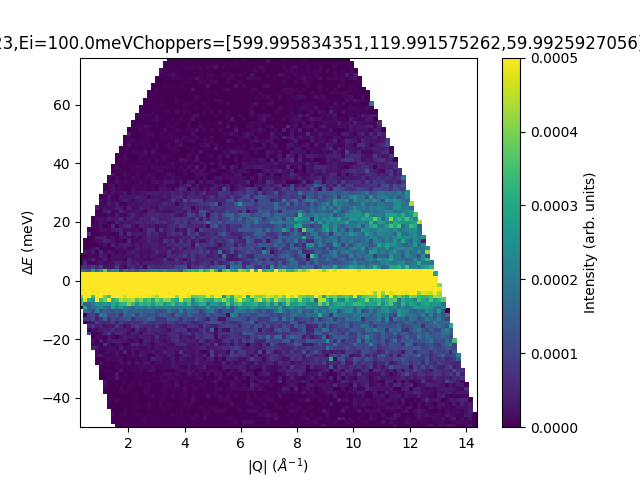

<IPython.core.display.Javascript object>


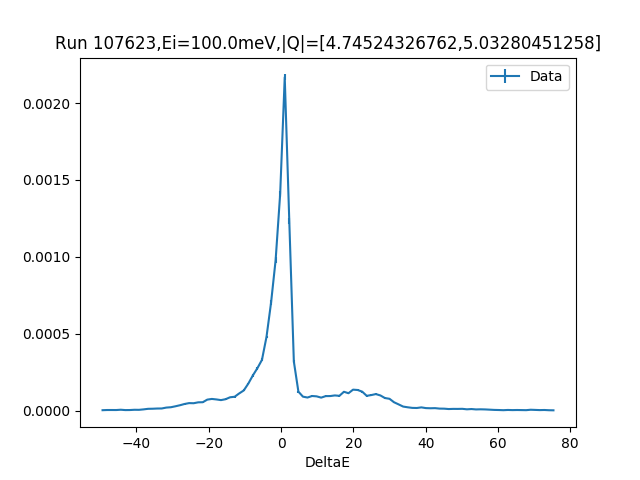

('Run=', 107623, ', Energy=', 100.0, 'meV, Chopper=', 1, 'ChopperPosition=', 0.6710330000000001)


In [36]:
PlotTag=1

data_table = {}

for RunNumber in RunNumbers:
    print (RunNumber)
    try:
        w=msa.CreateSingleValuedWorkspace()
        #LoadNexusLogs(w,"/SNS/ARCS/IPTS-"+str(IPTS)+"/data/ARCS_"+str(RunNumber)+'_event.nxs')
        msa.LoadNexusLogs(w,"/SNS/ARCS/IPTS-"+str(IPTS)+"/nexus/ARCS_"+str(RunNumber)+'.nxs.h5')
        RunParams=w.getRun()
        Energy=RunParams["BL18:Chop:Skf0:EnergyUserReq"].getStatistics().mean
        #print Energy
        Chopperpos=RunParams["chtrans"].getStatistics().mean
        #print Chopperpos
        Chopper1=RunParams["Speed1"].getStatistics().mean
        Chopper2=RunParams["Speed2"].getStatistics().mean
        Chopper3=RunParams["Speed3"].getStatistics().mean
        if Chopperpos>400: 
            Chopper=2 
        elif Chopperpos<1: 
            Chopper=1 
        else: 
            Chopper=0

        
        # generate a nice 2D multi-dimensional workspace
        data = msa.LoadNXSPE(datadir+'ARCS_'+str(RunNumber)+'_autoreduced.nxspe')
        values=msa.ConvertToMDMinMaxLocal('data',QDimensions='|Q|', dEAnalysisMode='Direct')
        minQ,minE=values.MinValues
        maxQ,maxE=values.MaxValues
        
        md = msa.ConvertToMD(InputWorkspace=data, QDimensions='|Q|', dEAnalysisMode='Direct')
        sqw = msa.BinMD(InputWorkspace=md,
                    AlignedDim0='|Q|,'+str(minQ)+','+str(maxQ)+',100',
                    AlignedDim1='DeltaE,'+ str(minE) +',' +str(maxE*0.8) +',100')

        #2D plot
        if PlotTag==1:
            fig, ax = plt.subplots(subplot_kw={'projection':'mantid'})
            c = ax.pcolormesh(sqw, vmin=0., vmax=0.5e-3)
            cbar=fig.colorbar(c)
            cbar.set_label('Intensity (arb. units)') #add text to colorbar
            ax.set_title('Run '+str(RunNumber)+',Ei='+str(Energy)+'meVChoppers=['+str(Chopper1)+','+str(Chopper2)+','+str(Chopper3)+']')
            fig.show()


        # generate a 1D multi-dimensional workspace


        sqw_line= msa.BinMD(
            InputWorkspace=md,
            #AlignedDim0='|Q|,' +str((minQ+maxQ)/3-0.01*maxQ) +','+ str((minQ+maxQ)/3+0.01*maxQ) +',1',
            AlignedDim0='|Q|,%s,%s,1' % ((minQ*2+maxQ)/3 , (minQ+2*maxQ)/3),
            AlignedDim1='DeltaE,'+ str(minE) +',' +str(maxE*0.8) +',100')

        sqw_line_Hist=msa.ConvertMDHistoToMatrixWorkspace('sqw_line', Normalization='NumEventsNormalization')

        # plots 1D multi-dimensional workspace
        if PlotTag==1:
            fig, ax = plt.subplots(subplot_kw={'projection':'mantid'})
            c = ax.errorbar(sqw_line_Hist,label='Data')
            ax.legend()
            ax.set_title('Run '+str(RunNumber)+',Ei='+str(Energy)+'meV,|Q|=[' +str((minQ+maxQ)/3-0.01*maxQ) +','+ str((minQ+maxQ)/3+0.01*maxQ) +']' )
            fig.show()
        xbb, y, Err = sqw_line_Hist.extractX(), sqw_line_Hist.extractY(), sqw_line_Hist.extractE()
        xbb.shape = y.shape = Err.shape = -1,
        x = (xbb[1:]+xbb[:-1])/2
        IE = x,y,Err

        RunParams2=data.getRun()
        Ei=RunParams2["Ei"].value
        Q=(minQ+maxQ)/3
        # array=[0,RunNumber, Energy, Ei, Chopper, round(Chopper1), round(Chopper2), round(Chopper3), Height, dHeight, Center, dCenter, Sigma, dSigma, Q]
        print("Run=",RunNumber,", Energy=",Energy,"meV, Chopper=",Chopper,"ChopperPosition=",Chopperpos)
        #print array
        data_table[RunNumber] = [
            Energy, Ei, 
            Chopper, round(Chopper1), round(Chopper2), round(Chopper3),
            IE,
            Q]
        
    except:
        raise
        print(RunNumber,": Errors, either file not in directory or some syntax, or fitting / plot errors")


# Fit

In [5]:
import dgsres

/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/mccomponents/homogeneous_scatterer/bindings/BoostPythonBinding.py:18: RuntimeWarning: to-Python converter for std::vector<int, std::allocator<int> > already registered; second conversion method ignored.
  import mccomponents.mccomponentsbp as binding
/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/mccomponents/homogeneous_scatterer/bindings/BoostPythonBinding.py:18: RuntimeWarning: to-Python converter for std::vector<double, std::allocator<double> > already registered; second conversion method ignored.
  import mccomponents.mccomponentsbp as binding


In [8]:
import lmfit

In [39]:
class EEModel:

    def __init__(self, sigma_left, sigma_right, weight_left, ef_width):
        self.sigma_left = sigma_left
        self.sigma_right = sigma_right
        self.weight_left = weight_left
        self.ef_width = ef_width
        return
    
    def __call__(self, x):
        from scipy.special import erfc
        from dgsres.singlextal import fit_2d_psf
        weight_left = self.weight_left
        weight_right = 1.0 - weight_left
        sigma_left = self.sigma_left
        sigma_right = self.sigma_right
        ef_width = self.ef_width
        t1 = fit_2d_psf.gaus(x, 1./np.sqrt(2*np.pi)/np.abs(sigma_left), 0., sigma_left) * (1-erfc(x/ef_width)/2.)
        t2 = fit_2d_psf.gaus(x, 1./np.sqrt(2*np.pi)/np.abs(sigma_right), 0., sigma_right) * erfc(x/ef_width)/2.
        return t1*weight_left + t2*weight_right
    

def lorentz(x, *p):
    I, gamma, x0 = p
    return I * gamma**2 / ((x - x0)**2 + gamma**2)

def model_func(x, h=1., sigma_left=1., sigma_right=1., weight_left=0.5, ef_width=1, h1=.1, gamma1=8, x1=-5):
    return (
        h*EEModel(sigma_left, sigma_right, weight_left, ef_width)(x) 
        + h1*lorentz(x, h1, gamma1, x1)
    )

model = lmfit.Model(model_func)


In [40]:
model.make_params()

Parameters([('gamma1', <Parameter 'gamma1', 8, bounds=[-inf:inf]>),
            ('h', <Parameter 'h', 1.0, bounds=[-inf:inf]>),
            ('h1', <Parameter 'h1', 0.1, bounds=[-inf:inf]>),
            ('ef_width', <Parameter 'ef_width', 1, bounds=[-inf:inf]>),
            ('weight_left', <Parameter 'weight_left', 0.5, bounds=[-inf:inf]>),
            ('sigma_left', <Parameter 'sigma_left', 1.0, bounds=[-inf:inf]>),
            ('sigma_right', <Parameter 'sigma_right', 1.0, bounds=[-inf:inf]>),
            ('x1', <Parameter 'x1', -5, bounds=[-inf:inf]>)])

In [41]:
data_table.keys()

[107623]

In [42]:
x,y,Err = data_table[107623][6]

In [43]:
Err=1e-10

In [46]:
fitres = model.fit(y[x<8], x=x[x<8], weights=1./Err)

<IPython.core.display.Javascript object>


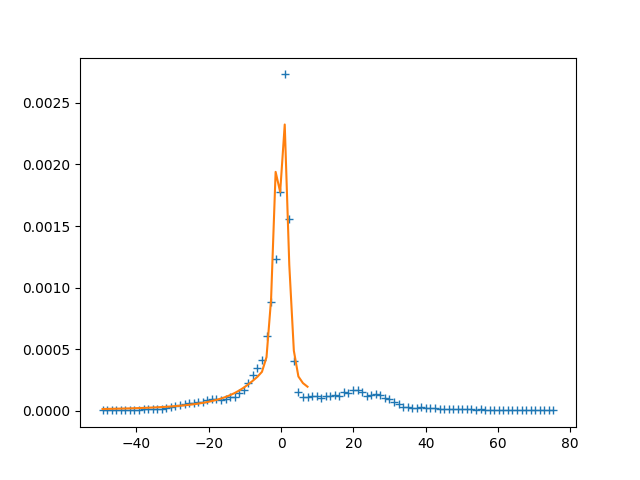

In [48]:
plt.figure()
plt.plot(x,y, '+')
plt.plot(x[x<8], fitres.best_fit)

Fit not very good

# Directly get FWHM using interpolation?

In [52]:
x_interp = np.arange(-20, 20, 0.01)

In [53]:
y_interp = np.interp(x_interp, x,y, )

In [61]:
import scipy
y_interp2 = scipy.interpolate.interp1d(x,y, kind='quadratic')(x_interp)

<IPython.core.display.Javascript object>


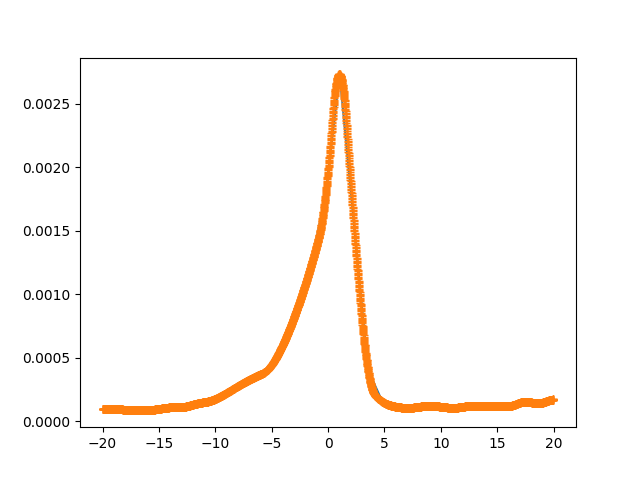

In [62]:
plt.figure()
plt.plot(x_interp, y_interp)
plt.plot(x_interp, y_interp2, '+')

In [65]:
ymax = np.max(y_interp2)
hm = ymax/2
middle = x_interp[y_interp2>hm]
print middle[-1]-middle[0]


3.51


Looks reasonable